# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [167]:
import nltk
import re
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
# узнаём немного в целом о столбцах и значениях в них
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# определяем кол-во NaN для каждого столбца в data
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# заполняем пропуски пустой строкой и проверяем, что оно сработало правильно
train = train.fillna('')
train.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


In [8]:
# заполняем пропуски пустой строкой и проверяем, что оно сработало правильно
test = test.fillna('')
test.head()

,id,keyword,location,text,target
2644,3796,destruction,,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

В обучающей выборке:
56.75% нулевых значений
43.25% единичных значений


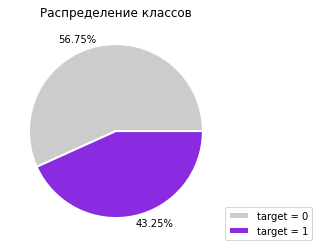

In [9]:
# Распределение классов в train
classes_train = train.groupby('target', as_index = False) \
                     .id \
                     .aggregate('count')

colors = ['#cccccc', '#8a2be2']
num_rows = classes_train.id.sum()
zeroes = str(round(classes_train.id[0] / num_rows * 100, 2))
ones = str(round(classes_train.id[1] / num_rows * 100, 2))
print('В обучающей выборке:', zeroes + '% нулевых значений', ones + '% единичных значений', sep='\n')

# Построим простенький pie chart
fig, ax = plt.subplots()
plt.title('Распределение классов')
ax.pie(classes_train.id, colors=colors, 
       wedgeprops={"linewidth": 2, "edgecolor": "white"}, 
       labels=[zeroes + '%', ones + '%'], labeldistance=1.08)
ax.legend(loc=(1,0), labels=['target = 0', 'target = 1'])
plt.show()

In [10]:
train.groupby('keyword', as_index=False).id.count().sort_values('id', ascending=False).head(10)

,keyword,id
0,,44
58,damage,36
179,siren,35
220,wreckage,34
105,fatalities,33
64,deluge,31
149,nuclear%20reactor,30
69,derail,30
91,emergency,30
106,fatality,30


In [11]:
df = train.groupby('keyword', as_index=False) \
          .target.aggregate(['sum', 'count']) \
          .sort_values('count', ascending=False) \
          .head(10)
df = df.assign(zeroes = df['count'] - df['sum'], ones = df['sum']) \
       .drop(['sum', 'count'], axis=1)
df.head()

,zeroes,ones
keyword,,
,12,32
damage,19,17
siren,31,4
wreckage,0,34
fatalities,17,16


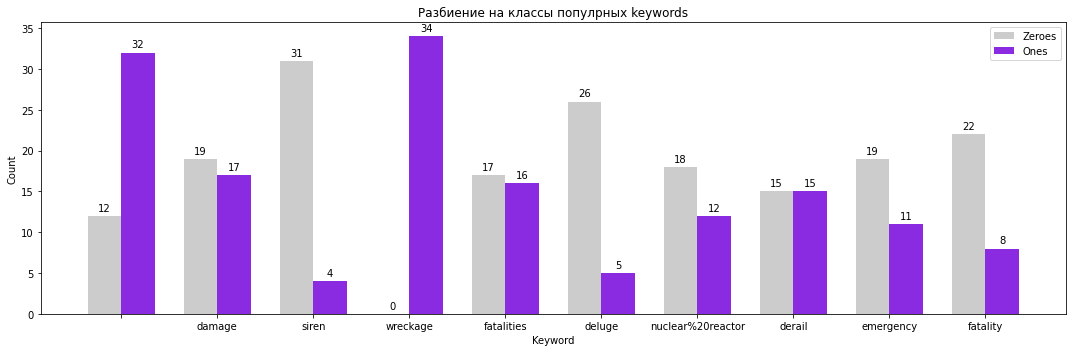

In [12]:
# отредачил пример с сайта матплотлиба
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = list(df.index)
zeroes = df.zeroes
ones = df.ones

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, zeroes, width, label='Zeroes', color=colors[0])
rects2 = ax.bar(x + width/2, ones, width, label='Ones', color=colors[1])

ax.set_ylabel('Count')
ax.set_xlabel('Keyword')
ax.set_title('Разбиение на классы популрных keywords')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Заметим, что среди 10 самых популярных (которые встречаются 30+ раз, при этом в выборку попали не все слова, встречающиеся ровно 30 раз) ключевых слов распределение между попаданием в категорию "1" и "0" равномерно далеко не всегда:

При ключевых словах 'siren', 'deluge', 'harm', 'twister' на обучающей выборке нолики встречаются значительно чаще, то есть речь не идёт об инциденте.
'wreckage' обладает обратным свойством - все тексты относятся к классу "1", то есть они относятся к катастрофе
При остальных ключевых словах наблюдается относительная сбалансированность классов

Стоит заметить, что общее число ноликов превышает кол-во единиц (193 против 126 соотвественно)

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [13]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [25]:
train['strings'] = train.keyword + ' ' + train.location + ' ' + train.text
train_concat = train.drop(train.columns[:-2], axis=1)
train_concat.head(8)

,target,strings
1186,0,bridge%20collapse Ashes 2015: AustraliaÛªs c...
4071,1,"hail Carol Stream, Illinois GREAT MICHIGAN TEC..."
5461,1,police Houston CNN: Tennessee movie theater s...
5787,1,rioting Still rioting in a couple of hours le...
7445,0,wounds Lake Highlands Crack in the path where ...
151,1,airplane%20accident Somewhere Out There Expert...
915,1,bloody Isolated City In World Perth 'I came to...
1305,0,burning @JohnsonTionne except idk them?? it's...


In [24]:
test['strings'] = test.keyword + ' ' + test.location + ' ' + test.text
test_concat = test.drop(test.columns[:-2], axis=1)
test_concat.head()

,target,strings
2644,1,destruction So you have a new weapon that can...
2227,0,deluge The f$&amp;@ing things I do for #GISHW...
5448,1,police UK DT @georgegalloway: RT @Galloway4May...
132,0,aftershock Aftershock back to school kick off...
6845,0,"trauma Montgomery County, MD in response to tr..."


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [16]:
cnt_vec = CountVectorizer()
w_per_text = cnt_vec.fit_transform(train_concat.strings)
pd.DataFrame(w_per_text.toarray(), 
             columns=cnt_vec.get_feature_names()).shape

c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(5329, 22738)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [17]:
dict_w = cnt_vec.vocabulary_
digits, punct, hashtag, mention = 0, 0, 0, 0

for word in dict_w:
    if re.search('\d', word):
        digits+=1
    if re.search('\W', word) or re.search('_', word):
        punct+=1
    if re.search('^#', word):
        hashtag += 1
    if re.search('^@', word):
        mention += 1
print('Токены с цифрами: %s' % digits,
      'Токены с пунктуацией: %s' % punct,
      'Токены с хэштэгами: %s' % hashtag,
      'Токены с упоминаниями: %s' % mention, sep='\n')

Токены с цифрами: 4590
Токены с пунктуацией: 317
Токены с хэштэгами: 0
Токены с упоминаниями: 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [19]:
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

tw = TweetTokenizer()
tw.tokenize('dskn nkjgn 09u34 sjkdn :) sd ')
tw_cnt_vec = CountVectorizer(tokenizer=tw.tokenize)

w_per_text = tw_cnt_vec.fit_transform(train_concat.strings)
print('Размер матрицы после Каунт Векторайзера: %s' % str(pd.DataFrame(w_per_text.toarray(), 
             columns=tw_cnt_vec.get_feature_names()).shape))


dict_tw = tw_cnt_vec.vocabulary_
digits, punct, hashtag, mention = 0, 0, 0, 0

for word in dict_tw:
    if re.search('\d', word):
        digits+=1
    if re.search('\W', word) or re.search('_', word):
        punct+=1
    if re.search('^#', word):
        hashtag += 1
    if re.search('^@', word):
        mention += 1
print('Токены с цифрами: %s' % digits,
      'Токены с пунктуацией: %s' % punct,
      'Токены с хэштэгами: %s' % hashtag,
      'Токены с упоминаниями: %s' % mention, sep='\n')

Размер матрицы после Каунт Векторайзера: (5329, 23874)
Токены с цифрами: 4609
Токены с пунктуацией: 7590
Токены с хэштэгами: 1474
Токены с упоминаниями: 1678


TweetTokenizer выделяет больше токенов, поэтому размер матрицы увеличился. В это число токенов попали и токены с хэштегами в начале, и упоминания, начинающиеся с символа "@". Общее число токенов с пунктуацией также выросло, а число токенов с числами осталось практически неизменным

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [20]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\egorb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
def egor_tokenizer(text: str):
    text_low = text.lower()
    tw = TweetTokenizer()
    tokens = tw.tokenize(text_low)
    token_g = tokens.copy()
    stop_words = stopwords.words('english')
    for i, token in enumerate(tokens): 
        if re.search('[^a-z]', token):
            if re.search('[(-)]', token) and re.search('\w', token) is None:
                continue
            if re.search('^#', token) and re.search('[^a-z]', token[1:]) is None:
                continue
            token_g.remove(token)
        elif token in stop_words:
            token_g.remove(token)
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(w) for w in token_g]
    return stemmed


for i in range(10):
    print(egor_tokenizer(train_concat.strings.iloc[i + 1]))
    
egor_tokenizer('34534 @egr #346 #gkl')

['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect', 'dead', 'exchang', 'shot']
['wreck', 'current', 'write', 'book', 'friggin', 'wreck', 'destiel', 'suck', '(', 'read', '

['#gkl']

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [112]:
egor_cnt_vec = CountVectorizer(tokenizer=egor_tokenizer)

w_tr = egor_cnt_vec.fit_transform(train_concat.strings)
tr_matrix = pd.DataFrame(w_tr.toarray(), 
                        columns=egor_cnt_vec.get_feature_names_out())
w_te = egor_cnt_vec.transform(test_concat.strings)
te_matrix = pd.DataFrame(w_te.toarray(), 
                        columns=egor_cnt_vec.get_feature_names_out())

In [100]:
X_tr = tr_matrix
y_tr = train_concat.target
X_te = te_matrix
y_te = test_concat.target
log_reg = LogisticRegression()
clf = log_reg.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

In [101]:
f1_0 = f1_score(y_te, y_pred)
print('f1-score на тестовых данных: %s' %round(f1_0, 3))

f1-score на тестовых данных: 0.753


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [161]:
def tfidf_vectorizer(train_concat, test_concat, max_df=1.0, min_df=0.0, tokenizer=egor_tokenizer):
    egor_cnt_tfidf = TfidfVectorizer(tokenizer=tokenizer, max_df=max_df, min_df=min_df)

    w_tr = egor_cnt_tfidf.fit_transform(train_concat.strings)
    tr_matrix = pd.DataFrame(w_tr.toarray(), 
                             columns=egor_cnt_tfidf.get_feature_names_out())
    w_te = egor_cnt_tfidf.transform(test_concat.strings)
    te_matrix = pd.DataFrame(w_te.toarray(), 
                             columns=egor_cnt_tfidf.get_feature_names_out())
    X_tr = tr_matrix
    y_tr = train_concat.target
    X_te = te_matrix
    y_te = test_concat.target
    log_reg = LogisticRegression()
    clf = log_reg.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    f1_1 = f1_score(y_te, y_pred)
    return 'f1-score на тестовых данных: %s' %round(f1_1, 3), 'Размер матрицы: %s' % str(X_tr.shape)

In [162]:
tfidf_vectorizer(train_concat, test_concat, max_df=1.0)

('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')

Заметим, что при применении tfidf векторайзера качество незначительно снизилось, а качество модели и размер матрицы оставались неизменнными до экстремально низких значений max_df, потому что получившийся словарь большой, а тексты (твиты) - маленькие. Получается, что, действительно, нет ни одного слова, которое будет встречаться даже в каждом пятом твите. Поэтому при выбросе токенов с df > 0.9 ни одно слово не ушло

In [163]:
for i in [1.0, 0.9, 0.5, 0.2, 0.05, 0.001]:   
    print('max_df=%s: %s' % (i, str(tfidf_vectorizer(train_concat, test_concat, max_df=i))))

max_df=1.0: ('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')
max_df=0.9: ('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')
max_df=0.5: ('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')
max_df=0.2: ('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')
max_df=0.05: ('f1-score на тестовых данных: 0.741', 'Размер матрицы: (5329, 10480)')
max_df=0.001: ('f1-score на тестовых данных: 0.433', 'Размер матрицы: (5329, 8741)')


При удалении токенов со слишком маленьким df матрица стремительно сокращается, потому что основную массу составляют токены, встречающиеся не более, чем в 10 твитах. Чаще, чем в каждом двадцатом твите встречаются лишь два слова.

In [166]:
for i in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:   
    print('min_df=%s: %s' % (i, str(tfidf_vectorizer(train_concat, test_concat, min_df=i))))

min_df=0.0001: ('f1-score на тестовых данных: 0.742', 'Размер матрицы: (5329, 10482)')
min_df=0.0005: ('f1-score на тестовых данных: 0.744', 'Размер матрицы: (5329, 3136)')
min_df=0.001: ('f1-score на тестовых данных: 0.745', 'Размер матрицы: (5329, 1741)')
min_df=0.005: ('f1-score на тестовых данных: 0.719', 'Размер матрицы: (5329, 394)')
min_df=0.01: ('f1-score на тестовых данных: 0.629', 'Размер матрицы: (5329, 127)')
min_df=0.05: ('f1-score на тестовых данных: 0.0', 'Размер матрицы: (5329, 2)')


## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [176]:
def hashing_vectorizer(train_concat, test_concat, n_features, tokenizer=egor_tokenizer):
    egor_cnt_tfidf = HashingVectorizer(tokenizer=tokenizer, n_features=n_features)

    w_tr = egor_cnt_tfidf.fit_transform(train_concat.strings)
    tr_matrix = pd.DataFrame(w_tr.toarray())
    w_te = egor_cnt_tfidf.transform(test_concat.strings)
    te_matrix = pd.DataFrame(w_te.toarray())
    X_tr = tr_matrix
    y_tr = train_concat.target
    X_te = te_matrix
    y_te = test_concat.target
    log_reg = LogisticRegression()
    clf = log_reg.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    f1_1 = f1_score(y_te, y_pred)
    return 'f1-score на тестовых данных: %s' %round(f1_1, 3), 'Размер матрицы: %s' % str(X_tr.shape)

In [177]:
hashing_vectorizer(train_concat, test_concat, n_features=5000)

('f1-score на тестовых данных: 0.719', 'Размер матрицы: (5329, 5000)')

In [179]:
for i in [100,1000,2500,5000,7500,9000,10000]:
    print('min_df=%s: %s' % (i, str(hashing_vectorizer(train_concat, test_concat, n_features=i))))

c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=100: ('f1-score на тестовых данных: 0.506', 'Размер матрицы: (5329, 100)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=1000: ('f1-score на тестовых данных: 0.667', 'Размер матрицы: (5329, 1000)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=2500: ('f1-score на тестовых данных: 0.696', 'Размер матрицы: (5329, 2500)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=5000: ('f1-score на тестовых данных: 0.719', 'Размер матрицы: (5329, 5000)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=7500: ('f1-score на тестовых данных: 0.733', 'Размер матрицы: (5329, 7500)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=9000: ('f1-score на тестовых данных: 0.721', 'Размер матрицы: (5329, 9000)')


c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


min_df=10000: ('f1-score на тестовых данных: 0.727', 'Размер матрицы: (5329, 10000)')


В итоге лучшим оказался CountVectorizer(), который показал результат больше 0.75 по метрике f1-score. Hashing и Tfidf даже при изменении некоторых параметров не смогли добиться таких же результатов

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [181]:
# копирую задание 8, потому что там и был лучший результат,
# который оказался больше 0.75

egor_cnt_vec = CountVectorizer(tokenizer=egor_tokenizer)

w_tr = egor_cnt_vec.fit_transform(train_concat.strings)
tr_matrix = pd.DataFrame(w_tr.toarray(), 
                        columns=egor_cnt_vec.get_feature_names_out())
w_te = egor_cnt_vec.transform(test_concat.strings)
te_matrix = pd.DataFrame(w_te.toarray(), 
                        columns=egor_cnt_vec.get_feature_names_out())
X_tr = tr_matrix
y_tr = train_concat.target
X_te = te_matrix
y_te = test_concat.target
log_reg = LogisticRegression()
clf = log_reg.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
f1_0 = f1_score(y_te, y_pred)
print('f1-score на тестовых данных: %s' %round(f1_0, 3))

f1-score на тестовых данных: 0.753
